In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
PATH = "./"
print(os.listdir(PATH))

# Any results you write to the current directory are saved as output.


['.ipynb_checkpoints', 'application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit-Copy1.ipynb', 'credit.ipynb', 'credit6-Copy1.ipynb', 'credit_bak.ipynb', 'credit_card_balance.csv', 'credit_cp.ipynb', 'credit_submit_data_0601_01.csv', 'credit_submit_data_0602_01.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'LGBM-Copy1.ipynb', 'LGBM.ipynb', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv', 'submission_0609.csv']


In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df


In [3]:
application_train = import_data(PATH+'application_train.csv')
application_test = import_data(PATH+'application_test.csv')

Memory usage of dataframe is 286.23 MB
Memory usage after optimization is: 59.54 MB
Decreased by 79.2%
Memory usage of dataframe is 45.00 MB
Memory usage after optimization is: 9.40 MB
Decreased by 79.1%


In [4]:
application_train = application_train[application_train['AMT_INCOME_TOTAL'] != 1.170000e+08]
application_train = application_train[application_train['AMT_REQ_CREDIT_BUREAU_QRT'] != 261]
application_train = application_train[application_train['OBS_30_CNT_SOCIAL_CIRCLE'] < 300]


In [5]:
application_train['DAYS_EMPLOYED'] = (application_train['DAYS_EMPLOYED'].apply(lambda x: x if x != 365243 else np.nan))


In [6]:
def feat_ext_source(df):
    x1 = df['EXT_SOURCE_1'].fillna(-1) + 1e-1
    x2 = df['EXT_SOURCE_2'].fillna(-1) + 1e-1
    x3 = df['EXT_SOURCE_3'].fillna(-1) + 1e-1
    
    df['EXT_SOURCE_1over2_NAminus1_Add0.1'] = x1/x2
    df['EXT_SOURCE_2over1_NAminus1_Add0.1'] = x2/x1
    df['EXT_SOURCE_1over3_NAminus1_Add0.1'] = x1/x3
    df['EXT_SOURCE_3over1_NAminus1_Add0.1'] = x3/x1
    df['EXT_SOURCE_2over3_NAminus1_Add0.1'] = x2/x3
    df['EXT_SOURCE_3over2_NAminus1_Add0.1'] = x3/x2
    
    df['EXT_SOURCE_na1_2'] = (df['EXT_SOURCE_1'].isnull()) * (df['EXT_SOURCE_2'].fillna(0))
    df['EXT_SOURCE_na1_3'] = (df['EXT_SOURCE_1'].isnull()) * (df['EXT_SOURCE_3'].fillna(0))
    df['EXT_SOURCE_na2_1'] = (df['EXT_SOURCE_2'].isnull()) * (df['EXT_SOURCE_1'].fillna(0))
    df['EXT_SOURCE_na2_3'] = (df['EXT_SOURCE_2'].isnull()) * (df['EXT_SOURCE_3'].fillna(0))
    df['EXT_SOURCE_na3_1'] = (df['EXT_SOURCE_3'].isnull()) * (df['EXT_SOURCE_1'].fillna(0))
    df['EXT_SOURCE_na3_2'] = (df['EXT_SOURCE_3'].isnull()) * (df['EXT_SOURCE_2'].fillna(0))
    
    return df


In [7]:
application_train = feat_ext_source(application_train)
application_test  = feat_ext_source(application_test)


In [8]:
# use this if you want to convert categorical features to dummies(default)
def cat_to_dummy(train, test):
    train_d = pd.get_dummies(train, drop_first=False)
    test_d = pd.get_dummies(test, drop_first=False)
    # make sure that the number of features in train and test should be same
    for i in train_d.columns:
        if i not in test_d.columns:
            if i!='TARGET':
                train_d = train_d.drop(i, axis=1)
    for j in test_d.columns:
        if j not in train_d.columns:
            if j!='TARGET':
                test_d = test_d.drop(i, axis=1)
    print('Memory usage of train increases from {:.2f} to {:.2f} MB'.format(train.memory_usage().sum() / 1024**2, 
                                                                            train_d.memory_usage().sum() / 1024**2))
    print('Memory usage of test increases from {:.2f} to {:.2f} MB'.format(test.memory_usage().sum() / 1024**2, 
                                                                            test_d.memory_usage().sum() / 1024**2))
    return train_d, test_d

application_train_ohe, application_test_ohe = cat_to_dummy(application_train, application_test)


Memory usage of train increases from 79.86 to 115.22 MB
Memory usage of test increases from 10.51 to 16.13 MB


In [9]:
# bureauデータの整形

bureau_data=pd.read_csv("bureau.csv")
# bureau_data.columns

bureau_data["CREDIT_CNT"]=1

cate_cols=['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE']

for tgt_col in cate_cols:
    tmp_DF=pd.get_dummies(bureau_data[tgt_col])
    tmp_DF.columns=[tgt_col+"_"+str(x) for x in tmp_DF.columns]
    bureau_data=pd.concat([bureau_data,tmp_DF],axis=1)
    del bureau_data[tgt_col]

del bureau_data["SK_ID_BUREAU"]

bureau_data["AMT_ANNUITY_BUREAU"]=bureau_data["AMT_ANNUITY"]
del bureau_data["AMT_ANNUITY"]

bureau_data2=bureau_data.fillna(0).groupby("SK_ID_CURR").sum().reset_index(drop=False)


In [10]:
# POS_CASHデータの整形

POS_data=pd.read_csv("POS_CASH_balance.csv")

#PREV_IDの数、SK_DPDの合計、SK_DPDの回数、分割数の平均
tmp_data1=POS_data.groupby(["SK_ID_CURR","SK_ID_PREV"]).mean()
tmp_data1["POS_ID_PREV_CNT"]=1
tmp_data1_2=tmp_data1.groupby(["SK_ID_CURR"]).sum()["POS_ID_PREV_CNT"]
tmp_data2=POS_data.groupby(["SK_ID_CURR"]).sum()["SK_DPD"]
POS_data["SK_DPD_CNT"]=POS_data["SK_DPD"].astype(bool).astype(int)
tmp_data3=POS_data.groupby(["SK_ID_CURR"]).sum()["SK_DPD_CNT"]
tmp_data4=tmp_data1.groupby(["SK_ID_CURR"]).sum()["CNT_INSTALMENT"]
POS_data2=pd.concat([tmp_data1_2,tmp_data2,tmp_data3,tmp_data4],axis=1)
POS_data2.columns=['POS_ID_PREV_CNT', 'POS_SK_DPD_SUM', 'POS_SK_DPD_CNT', 'POS_CNT_INSTALMENT_MEAN']
POS_data2=POS_data2.reset_index()

In [11]:
# previous_applicationデータの加工
def grep_include(lst,word):
    tgt = []
    for string in lst:
        if string.find(word) != -1: #wordがstringに含まれている
            tgt.append(string)
    return tgt

prev_app=pd.read_csv("previous_application.csv")
prev_app=prev_app.replace("XNA",np.nan)
print(prev_app.shape)
print(len(prev_app["SK_ID_CURR"].value_counts()))

print(len(prev_app.sort_values(["SK_ID_CURR","SK_ID_PREV"])))
# 2種類のIDの組み合わせはユニークらしい

prev_app2=prev_app.copy()
#prev_app2["FLAG_LAST_APPL_PER_CONTRACT"]=prev_app2["FLAG_LAST_APPL_PER_CONTRACT"].replace("Y",1).replace("N",0)
for tgt_col in ["NAME_CONTRACT_TYPE","WEEKDAY_APPR_PROCESS_START","NAME_CASH_LOAN_PURPOSE","NAME_CONTRACT_STATUS",
                     "NAME_PAYMENT_TYPE","CODE_REJECT_REASON","NAME_TYPE_SUITE","NAME_CLIENT_TYPE","NAME_GOODS_CATEGORY",
                     "NAME_PORTFOLIO","NAME_PRODUCT_TYPE","FLAG_LAST_APPL_PER_CONTRACT","CHANNEL_TYPE","NAME_SELLER_INDUSTRY",
                     "NAME_YIELD_GROUP","PRODUCT_COMBINATION"]:
    #print(tgt_col)
    tmp_DF=pd.get_dummies(prev_app2[tgt_col])
    tmp_DF.columns=[tgt_col+"_"+str(x) for x in tmp_DF.columns]

    prev_app2=pd.concat([prev_app2,tmp_DF],axis=1)
    del prev_app2[tgt_col]
    
prev_app2_cate=pd.concat([prev_app2[prev_app2.columns[1:2]],prev_app2[prev_app2.columns[21:]]],axis=1)
prev_app2_cont=prev_app2[prev_app2.columns[:21]]
prev_app2_cont["HOUR_APPR_PROCESS_START"]=prev_app2_cont["HOUR_APPR_PROCESS_START"].replace(0,24).replace(1,25).replace(2,26)

print(grep_include(prev_app2_cont.columns,"FLAG")) # フラグをカテゴリとするかは、後日検討
print(len(prev_app["SK_ID_CURR"].value_counts()))
# 案：キャンセルになったレコードを削除する or しないで２パターン試す →削除するほうがよい
print(len(prev_app[prev_app["NAME_CONTRACT_STATUS"]!="Canceled"]["SK_ID_CURR"].value_counts()))

prev_app2_cont=prev_app2_cont[prev_app2["NAME_CONTRACT_STATUS_Canceled"]!=1]
del prev_app2_cont["SK_ID_PREV"]
prev_app_cont_mean=prev_app2_cont.groupby("SK_ID_CURR").mean()

col_lst_prev_app=[]
for tmp_col in prev_app_cont_mean.columns:
    if prev_app_cont_mean[tmp_col].value_counts().sum()/len(prev_app_cont_mean) > 0.95:
        col_lst_prev_app.append(tmp_col)

print(len(prev_app_cont_mean))
print(len(prev_app_cont_mean[col_lst_prev_app].dropna()))
print(len(col_lst_prev_app))

# ⑤データ
prev_app_cont_mean=prev_app_cont_mean[col_lst_prev_app].dropna()
#prev_app2_cont.sort_values("SK_ID_CURR")
prev_app_cont_mean.columns=["6_"+str(x)+"_mean" for x in prev_app_cont_mean.columns]
prev_app_cont_mean=prev_app_cont_mean.reset_index()

# ⑥データ
prev_app_cate_sum=prev_app2_cate.groupby("SK_ID_CURR").sum()
prev_app_cate_sum.columns=["6_"+str(x)+"_sum" for x in prev_app_cate_sum.columns]
prev_app_cate_sum=prev_app_cate_sum.reset_index()

(1670214, 37)
338857
1670214


C:\Users\userpc\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


['NFLAG_LAST_APPL_IN_DAY', 'NFLAG_INSURED_ON_APPROVAL']
338857
338602
338602
336519
15


In [14]:
# installments_paymentsデータの加工
inst_pay=pd.read_csv("installments_payments.csv")
inst_pay=inst_pay.replace("XNA",np.nan)
del inst_pay["NUM_INSTALMENT_VERSION"]
#inst_pay2=inst_pay.merge(flag_data,on="SK_ID_CURR",how="left")
#print(inst_pay2.shape)

inst_pay2=inst_pay.sort_values(["SK_ID_CURR","SK_ID_PREV","NUM_INSTALMENT_NUMBER"])
#inst_pay.tail(10)
inst_pay2["DIFF_DAYS"]=inst_pay2["DAYS_INSTALMENT"]-inst_pay2["DAYS_ENTRY_PAYMENT"]
inst_pay2["DIFF_AMT"]=inst_pay2["AMT_INSTALMENT"]-inst_pay2["AMT_PAYMENT"]

inst_pay2_aggr=inst_pay2.groupby("SK_ID_CURR").mean().reset_index()

inst_pay_aggr2=inst_pay2_aggr[["SK_ID_CURR","DIFF_DAYS","DIFF_AMT"]]
inst_pay_aggr2.columns=["SK_ID_CURR","7_DIFF_DAYS_MEAN","7_DIFF_AMT_MEAN"]

# ⑦データ
inst_pay_aggr2=inst_pay_aggr2.dropna()
print(inst_pay_aggr2.shape)

(339578, 3)


In [15]:
len(application_train_ohe)

306487

In [18]:
application_train_ohe2=application_train_ohe.merge(bureau_data2,on="SK_ID_CURR",how="inner").merge(POS_data2,on="SK_ID_CURR",how="inner").merge(prev_app_cate_sum,on="SK_ID_CURR",how="inner").merge(prev_app_cont_mean,on="SK_ID_CURR",how="inner").merge(inst_pay_aggr2,on="SK_ID_CURR",how="inner")
application_test_ohe2=application_test_ohe.merge(bureau_data2,on="SK_ID_CURR",how="inner").merge(POS_data2,on="SK_ID_CURR",how="inner").merge(prev_app_cate_sum,on="SK_ID_CURR",how="inner").merge(prev_app_cont_mean,on="SK_ID_CURR",how="inner").merge(inst_pay_aggr2,on="SK_ID_CURR",how="inner")


In [10]:
#application_train_ohe, application_test_ohe = (application_train, application_test)


In [19]:
#from imblearn.under_sampling import RandomUnderSampler
#rus = RandomUnderSampler(random_state=314)
#X_rus, y_rus = rus.fit_sample(application_train_ohe.drop(['SK_ID_CURR', 'TARGET'], axis=1).fillna(-1), 
#                              application_train_ohe['TARGET'])

# You can use the full sample and do sample weighting in lightgbm using `is_unbalance` OR `scale_pos_weight` argument
# But it makes the code to run 8x..10x slower, which is ok for the run with pre-optimised parametersm but is too slow for HP optimisation
X_rus, y_rus = (application_train_ohe2.drop(['SK_ID_CURR', 'TARGET'], axis=1),
                application_train_ohe2['TARGET'])


In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus, test_size=0.20, random_state=314, stratify=y_rus)


In [21]:
def learning_rate_010_decay_power_099(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_010_decay_power_0995(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.995, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_005_decay_power_099(current_iter):
    base_learning_rate = 0.05
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3


In [22]:
import lightgbm as lgb
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'auc', 
            "eval_set" : [(X_test,y_test)],
            'eval_names': ['valid'],
            #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
            'verbose': 100,
            'categorical_feature': 'auto'}


In [23]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}


In [24]:
#This parameter defines the number of HP points to be tested
n_HP_points_to_test = 100

import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 1000 define only the absolute maximum
clf = lgb.LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=1000)
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=3,
    refit=True,
    random_state=314,
    verbose=True)


In [25]:
#gs.fit(X_train, y_train, **fit_params)
#print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))


In [26]:
opt_parameters = {'colsample_bytree': 0.9234, 'min_child_samples': 399, 'min_child_weight': 0.1, 'num_leaves': 13, 'reg_alpha': 2, 'reg_lambda': 5, 'subsample': 0.855}


In [27]:
clf_sw = lgb.LGBMClassifier(**clf.get_params())
#set optimal parameters
clf_sw.set_params(**opt_parameters)


LGBMClassifier(boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.9234, learning_rate=0.1, max_depth=-1,
        metric='None', min_child_samples=399, min_child_weight=0.1,
        min_split_gain=0.0, n_estimators=1000, n_jobs=4, num_leaves=13,
        objective=None, random_state=314, reg_alpha=2, reg_lambda=5,
        silent=True, subsample=0.855, subsample_for_bin=200000,
        subsample_freq=1)

In [28]:
gs_sample_weight = GridSearchCV(estimator=clf_sw, 
                                param_grid={'scale_pos_weight':[1,2,6,12]},
                                scoring='roc_auc',
                                cv=5,
                                refit=True,
                                verbose=True)


In [29]:
gs_sample_weight.fit(X_train, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(gs_sample_weight.best_score_, gs_sample_weight.best_params_))


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.772873
[200]	valid's auc: 0.778172
Early stopping, best iteration is:
[231]	valid's auc: 0.778825
Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.772899
[200]	valid's auc: 0.778156
Early stopping, best iteration is:
[230]	valid's auc: 0.778558
Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.771689
[200]	valid's auc: 0.777488
Early stopping, best iteration is:
[256]	valid's auc: 0.778433
Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.772799
[200]	valid's auc: 0.778739
[300]	valid's auc: 0.77941
Early stopping, best iteration is:
[330]	valid's auc: 0.779583
Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.772105
[200]	valid's auc: 0.777643
Early stopping, best iteration is:
[240]	valid's auc: 0.77894
Training 

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 16.1min finished


Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.773325
[200]	valid's auc: 0.779873
Early stopping, best iteration is:
[261]	valid's auc: 0.780994
Best score reached: 0.7770636200467047 with params: {'scale_pos_weight': 1} 


In [30]:
#print("Valid+-Std     Train  :   Parameters")
#for i in np.argsort(gs.cv_results_['mean_test_score'])[-5:]:
#    print('{1:.3f}+-{3:.3f}     {2:.3f}   :  {0}'.format(gs.cv_results_['params'][i], 
#                                    gs.cv_results_['mean_test_score'][i], 
#                                    gs.cv_results_['mean_train_score'][i],
#                                    gs.cv_results_['std_test_score'][i]))


In [31]:
print("Valid+-Std     Train  :   Parameters")
for i in np.argsort(gs_sample_weight.cv_results_['mean_test_score'])[-5:]:
    print('{1:.3f}+-{3:.3f}     {2:.3f}   :  {0}'.format(gs_sample_weight.cv_results_['params'][i], 
                                    gs_sample_weight.cv_results_['mean_test_score'][i], 
                                    gs_sample_weight.cv_results_['mean_train_score'][i],
                                    gs_sample_weight.cv_results_['std_test_score'][i]))


Valid+-Std     Train  :   Parameters
0.776+-0.003     0.833   :  {'scale_pos_weight': 12}
0.777+-0.004     0.830   :  {'scale_pos_weight': 2}
0.777+-0.004     0.834   :  {'scale_pos_weight': 6}
0.777+-0.004     0.824   :  {'scale_pos_weight': 1}


C:\Users\userpc\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [32]:
#Configure from the HP optimisation
#clf_final = lgb.LGBMClassifier(**gs.best_estimator_.get_params())

#Configure locally from hardcoded values
clf_final = lgb.LGBMClassifier(**clf.get_params())
#set optimal parameters
clf_final.set_params(**opt_parameters)

#force larger number of max trees and smaller learning rate
clf_final.set_params(n_estimators=5000, learning_rate=0.005, objective='binary')
clf_final.fit(X_train, y_train, **fit_params, callbacks=[lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_0995)])


Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.769634
[200]	valid's auc: 0.776833
[300]	valid's auc: 0.778826
[400]	valid's auc: 0.779537
[500]	valid's auc: 0.779983
[600]	valid's auc: 0.78027
[700]	valid's auc: 0.780368
[800]	valid's auc: 0.780443
[900]	valid's auc: 0.780488
[1000]	valid's auc: 0.780524
[1100]	valid's auc: 0.780554
[1200]	valid's auc: 0.780585
[1300]	valid's auc: 0.780611
[1400]	valid's auc: 0.78064
[1500]	valid's auc: 0.780673
[1600]	valid's auc: 0.780697
[1700]	valid's auc: 0.780719
[1800]	valid's auc: 0.780745
[1900]	valid's auc: 0.780768
[2000]	valid's auc: 0.780788
[2100]	valid's auc: 0.780819
[2200]	valid's auc: 0.780849
[2300]	valid's auc: 0.780871
[2400]	valid's auc: 0.780891
[2500]	valid's auc: 0.780912
[2600]	valid's auc: 0.780938
[2700]	valid's auc: 0.780965
[2800]	valid's auc: 0.78099
[2900]	valid's auc: 0.781019
[3000]	valid's auc: 0.781039
[3100]	valid's auc: 0.78107
[3200]	valid's auc: 0.781097
[3300]	valid's auc: 0.7

LGBMClassifier(boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.9234, learning_rate=0.005, max_depth=-1,
        metric='None', min_child_samples=399, min_child_weight=0.1,
        min_split_gain=0.0, n_estimators=5000, n_jobs=4, num_leaves=13,
        objective='binary', random_state=314, reg_alpha=2, reg_lambda=5,
        silent=True, subsample=0.855, subsample_for_bin=200000,
        subsample_freq=1)

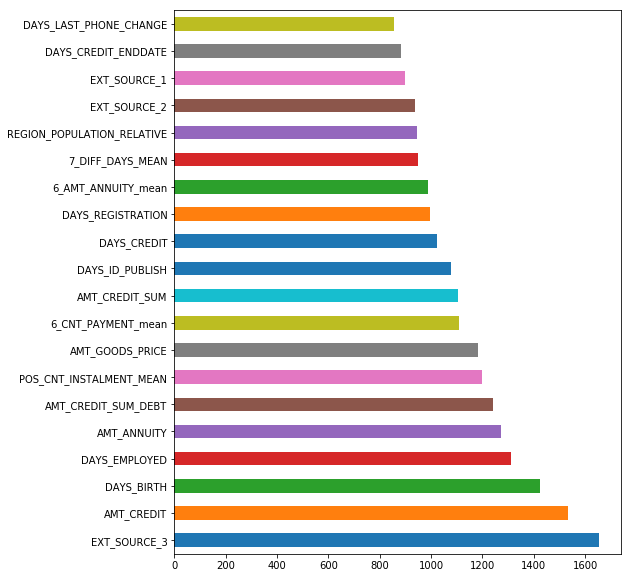

In [36]:
feat_imp = pd.Series(clf_final.feature_importances_, index=application_train_ohe2.drop(['SK_ID_CURR', 'TARGET'], axis=1).columns)
feat_imp.nlargest(20).plot(kind='barh', figsize=(8,10))


In [37]:
probabilities = clf_final.predict_proba(application_test_ohe2.drop(['SK_ID_CURR'], axis=1))
submission = pd.DataFrame({
    'SK_ID_CURR': application_test_ohe2['SK_ID_CURR'],
    'TARGET':     [ row[1] for row in probabilities]
})
#submission.to_csv("submission_0609-02.csv", index=False)


In [38]:
len(submission)

41250

In [39]:
submission.columns=["SK_ID_CURR","TARGET2"]
submission=submission.set_index("SK_ID_CURR")
submission2=pd.read_csv("submission_0609.csv").set_index("SK_ID_CURR")
submission2.loc[submission.index,"TARGET"]=submission["TARGET2"]

In [40]:
len(submission2)

48744

In [41]:
submission2.to_csv("submission_0609-02.csv", index=True)  #ベスト

In [29]:
len(X_train)

245189

In [31]:
len(application_test_ohe)

48744